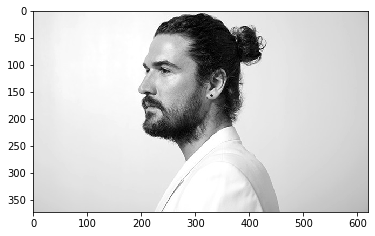

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "data"

CATEGORIES = ["men", "women"]

for category in CATEGORIES:  # do men and womens
    path = os.path.join(DATADIR,category)  # create path to mens and womens
    for img in os.listdir(path):  # iterate over each image per men and dogs
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [3]:
print(img_array)

[[226 226 226 ... 198 198 197]
 [226 226 227 ... 199 198 198]
 [226 226 227 ... 199 199 198]
 ...
 [202 203 203 ... 179 178 177]
 [202 202 203 ... 178 178 177]
 [201 202 202 ... 178 177 177]]


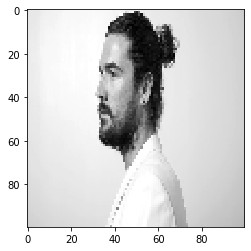

In [4]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [5]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do mens and womens

        path = os.path.join(DATADIR,category)  # create path to mens and womens
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=men 1=women

        for img in tqdm(os.listdir(path)):  # iterate over each image per mens and womens
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 1912/1912 [00:41<00:00, 46.24it/s]

3311


In [6]:
import random

random.shuffle(training_data)

In [7]:
for sample in training_data[:10]:
    print(sample[1])

1
1
0
1
0
1
0
1
0
0


In [8]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[146]
   [146]
   [146]
   ...
   [146]
   [146]
   [146]]

  [[148]
   [148]
   [148]
   ...
   [148]
   [148]
   [148]]

  [[148]
   [148]
   [148]
   ...
   [148]
   [148]
   [148]]

  ...

  [[148]
   [148]
   [148]
   ...
   [ 65]
   [ 43]
   [ 31]]

  [[148]
   [148]
   [148]
   ...
   [ 73]
   [ 51]
   [ 37]]

  [[148]
   [148]
   [148]
   ...
   [ 58]
   [ 48]
   [ 35]]]]


In [9]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [10]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.3,
                      callbacks=[tensorboard])

model.save('64x3-CNN.model')

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES = ["Dog", "Cat"]  # will use this to convert prediction num to string value


def prepare(filepath):
    IMG_SIZE = 70  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # read in the image, convert to grayscale
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # return the image with shaping that TF wants.

# we want to load our model:
model = tf.keras.models.load_model("64x3-CNN.model")

#we can make a prediction
prediction = model.predict([prepare('dog.jpg')])  # REMEMBER YOU'RE PASSING A LIST OF THINGS YOU WISH TO PREDICT

prediction
print(CATEGORIES[int(prediction[0][0])])
#output:Dog


#We can also test our cat example:
prediction = model.predict([prepare('cat.jpg')])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])
[[1.]]

# output:Cat

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES = ["Dog", "Cat"]


def prepare(filepath):
    IMG_SIZE = 70  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


model = tf.keras.models.load_model("64x3-CNN.model")

prediction = model.predict([prepare('doggo.jpg')])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])
[[0.]]
# output:Dog

# There you have how to use your model to predict new samples.